#### Training a CNN for Estimating Person Age and Predicting its Gender from its Image.

###### 1. Import the Relevent Packages

In [1]:
import torch
import numpy as np, cv2, pandas as pd, glob, time
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import warnings
warnings.filterwarnings("ignore")

###### 2. Fetch the Dataset

In [2]:
# From https://stackoverflow.com/a/39225039/4126114
import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)
     

In [3]:
#download_file_from_google_drive('1k5vvyREmHDW5TSM9QgB04Bvc8C8_7dl-','fairface-label-train.csv')

In [4]:
#download_file_from_google_drive('1_rtz1M1zhvS0d5vVoXUamnohB6cJ02iJ','fairface-label-val.csv')

In [5]:
#download_file_from_google_drive('1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86','fairface-img-margin025-trainval.zip')

In [6]:
#!unzip fairface-img-margin025-trainval.zip

In [7]:
train_df = pd.read_csv('fairface-label-train.csv')
validation_df = pd.read_csv('fairface-label-val.csv')

In [8]:
train_df.head()

,file,age,gender,race,service_test
0,train/1.jpg,59,Male,East Asian,True
1,train/2.jpg,39,Female,Indian,False
2,train/3.jpg,11,Female,Black,False
3,train/4.jpg,26,Female,Indian,True
4,train/5.jpg,26,Female,Indian,True


In [9]:
validation_df.head()

,file,age,gender,race,service_test
0,val/1.jpg,11,Male,East Asian,False
1,val/2.jpg,51,Female,East Asian,True
2,val/3.jpg,37,Male,White,True
3,val/4.jpg,25,Female,Latino_Hispanic,True
4,val/5.jpg,24,Male,Southeast Asian,False


###### 3. Preparing the Dataset

In [10]:
class GenderAge(Dataset):
    def __init__(self,df,tfms=None):
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, indx):
        person = self.df.iloc[indx].squeeze()
        image_path = person.file
        gender = person.gender == 'Female'
        age = person.age
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        return image, age , gender
    
    def preprocess_image(self,image):
        image = cv2.resize(image, (224,224))
        image = torch.tensor(image).permute(2,0,1)
        image = self.normalize(image/255.)
        
        return image[None]
    
    def collate_fn(self,batch):
        images, ages, genders = [],[],[]
        for image, age, gender in batch:
            image = self.preprocess_image(image)
            images.append(image)
            ages.append(float(int(age)/80))
            genders.append(float(gender))
            
        ages, genders = [torch.tensor(x).to(device).float() for x in [ages, genders]]
        images = torch.cat(images).to(device)
        
        
        return images, ages, genders   

In [11]:
train_dataset = GenderAge(train_df[:15000])
validation_dataset = GenderAge(validation_df[:3000])

In [12]:
train_dataset_loader = DataLoader(train_dataset,
                                  batch_size=32,
                                  shuffle=True,
                                  drop_last=True,
                                  collate_fn=train_dataset.collate_fn
                                 )
validation_dataset_loader = DataLoader(validation_dataset, 
                                      batch_size=32, 
                                      shuffle=True, 
                                      drop_last=True,
                                      collate_fn=validation_dataset.collate_fn)

In [13]:
images_batch,ages_batch,genders_batch = next(iter(train_dataset_loader))

In [14]:
images_batch.shape

torch.Size([32, 3, 224, 224])

In [15]:
ages_batch.shape

torch.Size([32])

In [16]:
genders_batch.shape

torch.Size([32])

###### 4. Building the Model

In [17]:
def build_model():
    vgg_16 = models.vgg16(pretrained = True)
    for parameter in vgg_16.parameters():
        parameter.requires_grad = False
    
    vgg_16.avgpool = nn.Sequential(
        nn.Conv2d(512,512, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten())
   
    class AgeGenderClassifier(nn.Module):
        def __init__(self):
            super(AgeGenderClassifier, self).__init__()
            self.intermediate = nn.Sequential(
                                                nn.Linear(2048,512),
                                                nn.ReLU(),
                                                nn.Dropout(0.4),
                                                nn.Linear(512,128),
                                                nn.ReLU(),
                                                nn.Dropout(0.4),
                                                nn.Linear(128,64),
                                                nn.ReLU()
                                              )
            self.age_classifier = nn.Sequential(
                                                nn.Linear(64, 1),
                                                nn.Sigmoid()
                                                )
            self.gender_classifier = nn.Sequential(
                                                nn.Linear(64, 1),
                                                nn.Sigmoid()
                                                )
        def forward(self, x):
            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)
            return gender, age
    
    vgg_16.classifier = AgeGenderClassifier()
    
    gender_loss_function = nn.BCELoss()
    age_loss_function = nn.L1Loss()
    loss_functions = gender_loss_function, age_loss_function
    optimizer = torch.optim.Adam(vgg_16.parameters(), lr = 1e-4)
    
    return vgg_16.to(device), loss_functions, optimizer

In [18]:
model, loss_functions, optimizer = build_model()

In [19]:
from torchsummary import summary
summary(model, input_size=(3,224,224), device=device)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (1,792)
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       (36,928)
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       (73,856)
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       (147,584)
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      (295,168)
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      (590,080)
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      (590,080)
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      (1,180,160)
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (1,792)
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       (36,928)
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       (73,856)
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       (147,584)
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      (295,168)
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      (590,080)
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      (590,080)
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      (1,180,160)
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-

###### 5. Define Training and validation Functions

In [20]:
def train_batch(batch, model, loss_functions, optimzier):
    model.train()
    images, ages, genders = batch
    predicted_genders, predicted_ages = model(images)
    gender_loss_function, age_loss_function = loss_functions
    gender_loss = gender_loss_function(predicted_genders.squeeze(),genders) 
    age_loss = age_loss_function(predicted_ages.squeeze(), ages)
    total_loss = gender_loss + age_loss
    total_loss.backward()
    optimizer.step()
  
    return total_loss.item()

In [21]:
@torch.no_grad()
def validate_batch(data, model, loss_functions):
    model.eval()
    images, ages, genders = batch
    predicted_gender, predicted_age = model(images)
    gender_loss_function, age_loss_function = loss_functions
    gender_loss = gender_loss_function(predicted_gender.squeeze(), genders)
    age_loss = age_loss_function(predicted_age.squeeze(), ages)
    total_loss = gender_loss + age_loss
    
    predicted_gender = (predicted_gender>0.5).squeeze()
    gender_accuracy = (predicted_gender == genders).float().sum()
    age_accuracy = torch.abs(ages - predicted_age).float().sum()
    
    return total_loss.item(), gender_accuracy, age_accuracy
    

In [22]:
train_losses = []
validation_losses = []
gender_accurcies = []
age_accuracies = []

for epoch in range(10):
    print(f"Epoch: {epoch+1}")
    epoch_train_losses =0
    epoch_valid_losses = 0
    epoch_valid_gender_acc =0
    epoch_valid_age_acc = 0
    ctr = 0
    for batch in iter(train_dataset_loader):
        batch_train_loss = train_batch(batch , model, loss_functions, optimizer)
        epoch_train_losses += batch_train_loss
    
    epoch_train_losses /= len(train_dataset_loader)
    train_losses.append(epoch_train_losses)
    print(f"Train Loss Value: {epoch_train_losses:0.3f}")
    
    for batch in iter(validation_dataset_loader):
        batch_valid_loss, batch_gender_acc, batch_age_acc = validate_batch(batch, model, loss_functions)
        epoch_valid_losses += batch_valid_loss
        epoch_valid_gender_acc += batch_gender_acc
        epoch_valid_age_acc += batch_age_acc
        ctr += len(batch[0])
    
    epoch_valid_losses /= len(validation_dataset_loader)
    validation_losses.append(epoch_valid_losses)
    print(f"Test Loss Value: {epoch_valid_losses:0.3f}")
    epoch_valid_gender_acc /=ctr
    gender_accurcies.append(epoch_valid_gender_acc)
    print(f"Gender Accuracy:{epoch_valid_gender_acc*100:0.0f}%")
    epoch_valid_age_acc /= ctr
    age_accuracies.append(epoch_valid_age_acc)
    print(f"Age Accuracy:{epoch_valid_age_acc:0.3f}")
    

Epoch: 1
Train Loss Value: 0.810
Test Loss Value: 0.724
Gender Accuracy:74%
Age Accuracy:6.371
Epoch: 2
Train Loss Value: 0.699
Test Loss Value: 0.780
Gender Accuracy:75%
Age Accuracy:7.153
Epoch: 3
Train Loss Value: 0.636
Test Loss Value: 0.642
Gender Accuracy:76%
Age Accuracy:5.792
Epoch: 4
Train Loss Value: 0.572
Test Loss Value: 0.665
Gender Accuracy:76%
Age Accuracy:5.629
Epoch: 5
Train Loss Value: 0.507
Test Loss Value: 0.639
Gender Accuracy:77%
Age Accuracy:5.746
Epoch: 6
Train Loss Value: 0.485
Test Loss Value: 0.648
Gender Accuracy:78%
Age Accuracy:5.479
Epoch: 7
Train Loss Value: 0.445
Test Loss Value: 0.714
Gender Accuracy:79%
Age Accuracy:5.710
Epoch: 8
Train Loss Value: 0.434
Test Loss Value: 0.746
Gender Accuracy:78%
Age Accuracy:5.478
Epoch: 9
Train Loss Value: 0.426
Test Loss Value: 0.755
Gender Accuracy:77%
Age Accuracy:5.520
Epoch: 10
Train Loss Value: 0.444
Test Loss Value: 0.726
Gender Accuracy:76%
Age Accuracy:5.645


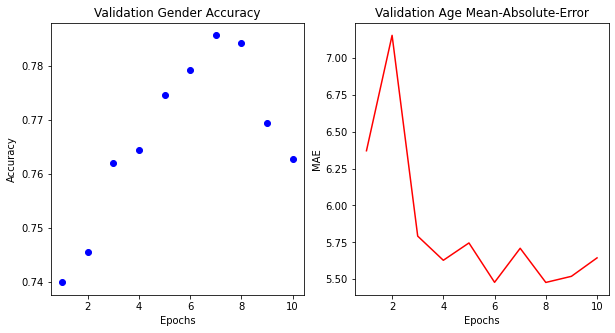

In [23]:
gender_accurcies_cpu = [item.detach().cpu().numpy().tolist() for item in gender_accurcies]
age_accuracies_cpu = [item.detach().cpu().numpy().tolist() for item in age_accuracies]
epochs = np.arange(1,(11))
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax = ax.flat
ax[0].plot(epochs, gender_accurcies_cpu, 'bo')
ax[1].plot(epochs, age_accuracies_cpu, 'r')
ax[0].set_xlabel('Epochs') 
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('MAE')
ax[0].set_title('Validation Gender Accuracy')
ax[1].set_title('Validation Age Mean-Absolute-Error')
plt.show()

###### Testing on a Random Image from the Validation Dataset

In [24]:
import random
indx = random.randint(0,len(validation_df))
image = cv2.imread(validation_df.iloc[indx,0])
image = train_dataset.preprocess_image(image)
gender, age = model(image.to(device))
predicted_gender = gender.to('cpu').detach().numpy()
predicted_age = age.to('cpu').detach().numpy()

The Predicted Gender: Male ; The Predicted Age 39


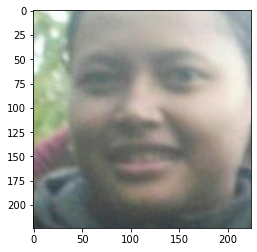

In [27]:
image = cv2.imread(validation_df.iloc[indx,0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
print('The Predicted Gender:',np.where(predicted_gender[0][0]<0.5, 'Male','Female'),\
      '; The Predicted Age', int(predicted_age[0][0]*80))

###### Testing on My Image

The Predicted Gender: Male ; The Predicted Age 20


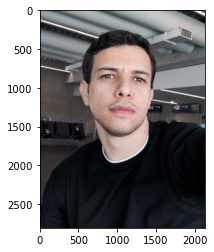

In [31]:
image = cv2.imread('IMG.jpg')
image = train_dataset.preprocess_image(image)
gender, age = model(image.to(device))
predicted_gender = gender.to('cpu').detach().numpy()
predicted_age = age.to('cpu').detach().numpy()
image = cv2.imread('IMG.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
print('The Predicted Gender:',np.where(predicted_gender[0][0]<0.5, 'Male','Female'),\
      '; The Predicted Age', int(predicted_age[0][0]*80))

##### The age estimation error is around 6 years. The model estimates my age as 20 when I was 26 in this photo. I only used part of the training data set due to my limited GPU